In [2]:
import xarray as xr
import cmocean
import cartopy
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pandas as pd

### First, let's download the SST dataset we'll be exploring

`wget https://github.com/anthony-meza/WHOI-PO-HPC/blob/official_pilot_workshop/data/sst.day.mean.2021.2023.nc`

In [4]:
### Opening netCDF dataset w/ xarray
# xarray supports a lot of different file formats, but netCDF is probably most common

ds = xr.open_dataset('../data/sst.day.mean.2021.2023.nc')

ds

<xarray.Dataset>
Dimensions:  (time: 1095, lat: 89, lon: 359)
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01 2021-01-02 ... 2023-12-31
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 81.0 83.0 85.0 87.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 354.0 355.0 356.0 357.0 358.0
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    regrid_method:  bilinear

In [ ]:
### How big is this dataset? What is the temporal and horizontal resolution? What variable does it include?

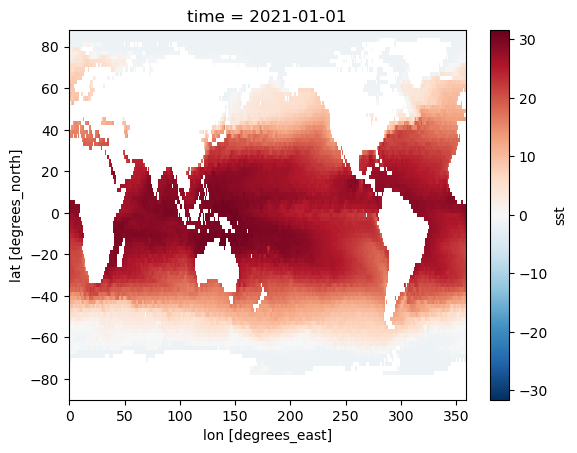

In [6]:
### Let's just start by plotting a single day of data

ds.isel(time=0).sst.plot.pcolormesh()

### Calculating monthly climatology of SST

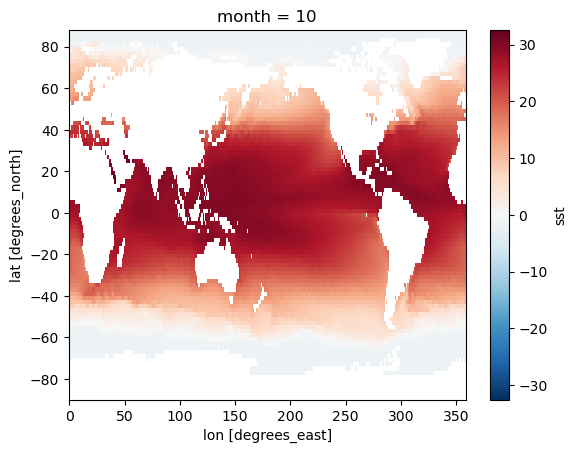

In [17]:
### We can easily compute statistical properties from this dataset

ds.groupby('time.month').mean().sel(month=10).sst.plot.pcolormesh()

Text(0.5, 1.0, 'October climatological SST')

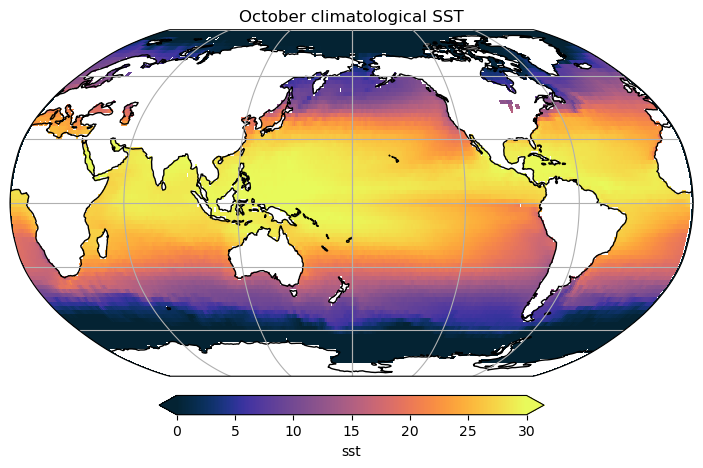

In [55]:
### Make it look a little nicer
cbar_kwargs = dict(orientation = "horizontal", fraction = 0.05, pad=0.05)
kwargs = dict(x='lon', y='lat',transform = ccrs.PlateCarree(), cbar_kwargs = cbar_kwargs)

fig, ax = plt.subplots(figsize=(10,5), subplot_kw={'projection':ccrs.Robinson(180)})
ds.groupby('time.month').mean().sel(month=10).sst.plot.pcolormesh(ax=ax, **kwargs, cmap=cmocean.cm.thermal, vmin=0, vmax=30)

ax.coastlines()
ax.gridlines()
ax.set_global()
ax.set_title('October climatological SST')

Text(0, 0.5, 'Monthly mean SST at 65W, 15N ($\\degree$C)')

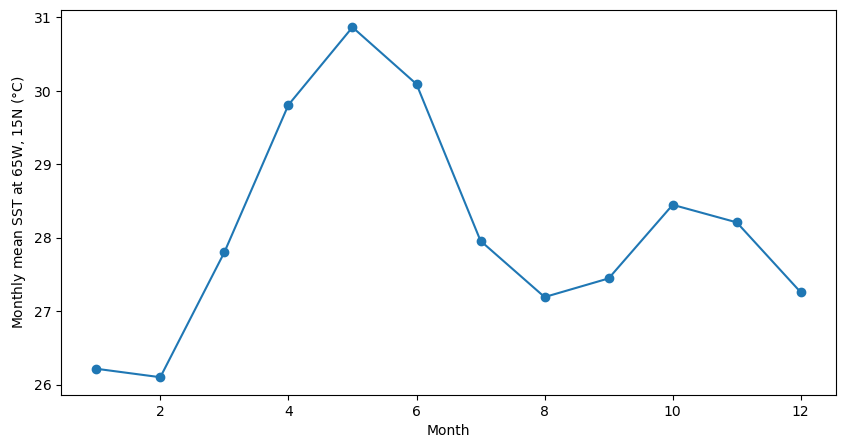

In [9]:
### Picking a point in the Arabian Sea to look at timeseries of the seasonal climatology
plon, plat = 65, 15

monthly_climatology = ds.sst.groupby('time.month').mean()

plt.figure(figsize=(10,5))
plt.plot(np.arange(1, 13), monthly_climatology.sel(lat=plat, lon=plon))
plt.scatter(np.arange(1, 13), monthly_climatology.sel(lat=plat, lon=plon))
plt.xlabel('Month')
plt.ylabel(f'Monthly mean SST at {plon}W, {plat}N'+r' ($\degree$C)')

### DIY exploration: What if you wanted to 
- Look at the monthly climatology at a different location?
- Look at the mean SST on non-monthly timescales?
- Look at a different statistic?

Report back on what you find!

### We may also be interested in deviations from the mean (e.g. anomaly from the seasonal climatology)

In [17]:
monthly_anomaly = (ds.sst.groupby("time.month") - monthly_climatology)

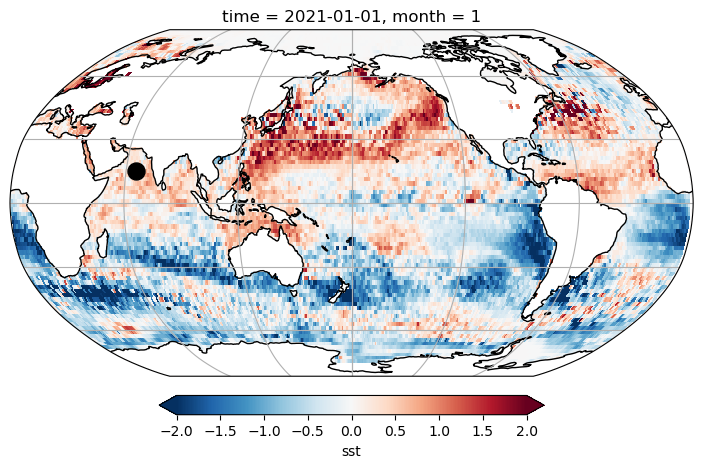

In [20]:
### First, let's look at the global anomaly at the start of our analysis period

cbar_kwargs = dict(orientation = "horizontal", fraction = 0.05, pad=0.05)
kwargs = dict(x='lon', y='lat',transform = ccrs.PlateCarree(), cbar_kwargs = cbar_kwargs)

fig, ax = plt.subplots(figsize=(10,5), subplot_kw={'projection':ccrs.Robinson(180)})

ax.coastlines()
ax.gridlines()
ax.set_global()

plt.scatter(plon, plat, s=150, zorder=10, color='black', transform = ccrs.PlateCarree())


(monthly_anomaly).isel(time=0).plot.pcolormesh(ax=ax, **kwargs, vmin=-2, vmax=2, cmap='RdBu_r')

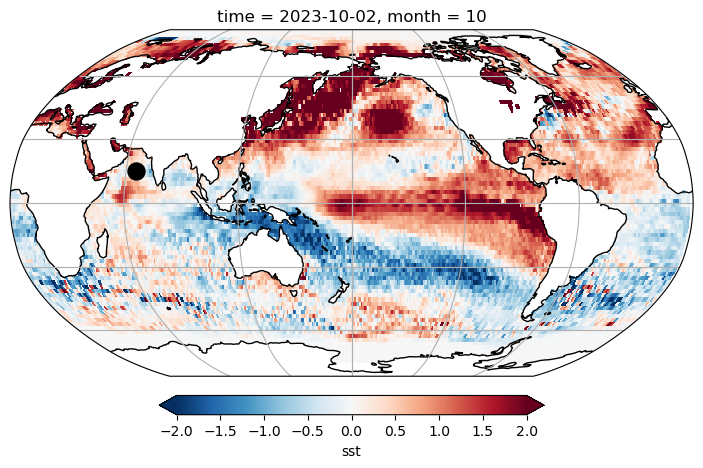

In [22]:
### First, let's look at the global anomaly at the start of our analysis period

cbar_kwargs = dict(orientation = "horizontal", fraction = 0.05, pad=0.05)
kwargs = dict(x='lon', y='lat',transform = ccrs.PlateCarree(), cbar_kwargs = cbar_kwargs)

fig, ax = plt.subplots(figsize=(10,5), subplot_kw={'projection':ccrs.Robinson(180)})

ax.coastlines()
ax.gridlines()
ax.set_global()

plt.scatter(plon, plat, s=150, zorder=10, color='black', transform = ccrs.PlateCarree())


(monthly_anomaly).sel(time='2023-10-02', method='nearest').plot.pcolormesh(ax=ax, **kwargs, vmin=-2, vmax=2, cmap='RdBu_r')

<Axes: >

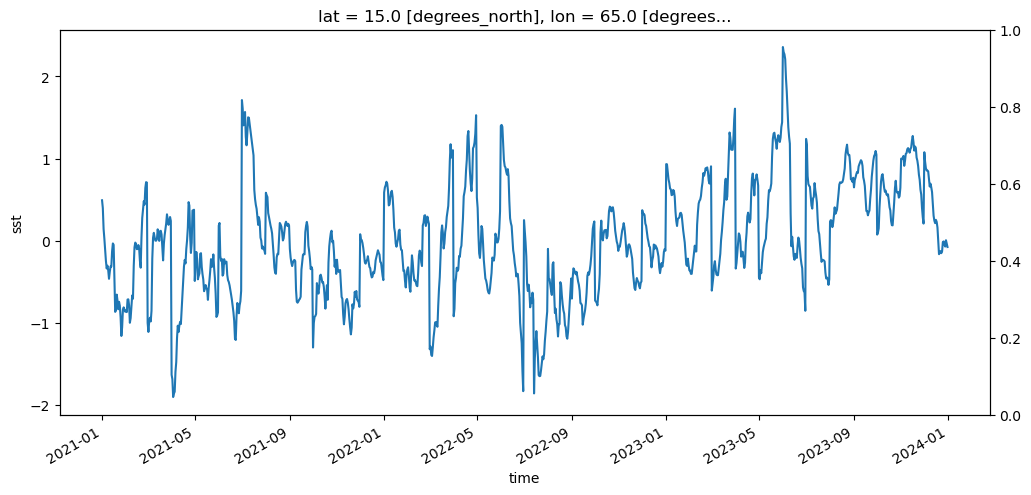

In [15]:
### Again, looking at this data at a single point

plt.figure(figsize=(12,5))
(ds.sst.groupby("time.month") - monthly_climatology).sel(lat=plat, lon=plon).plot()
plt.twinx()

In [239]:
### Some useful tidbits of code if you want to replot the monthly climatology 
# on the same axis as your anomaly
# date_range = xr.date_range("2021-01-01", "2024-01-01", freq="MS")

# # access the month index (1, 2, ..., 12) for each date:
# months = date_range.month

# # create a DataArray from the above. The coordinate is the full date range
# # and will become the time dim in the result. The values are the months
# # that we would like to select from the climatology
# selector = xr.DataArray(months, dims=["time"], coords=[date_range])

# # select from the climatology, reshaping to be indexed by `time`
# time_series = monthly_climatology.sel(month=selector)

# monthly_anomaly = (ds.sst.groupby("time.month") - monthly_climatology)

# plt.figure(figsize=(12,5))
# monthly_anomaly.sel(lat=plat, lon=plon).plot()
# plt.ylabel('SST anomaly from climatology ($\degree$C)')
# plt.twinx()
# time_series.sel(lat=plat, lon=plon).plot(zorder=-1, color='orange',ls='--')
# plt.xlim(pd.to_datetime('2021-01-01'), pd.to_datetime('2024-01-01'))
# plt.ylabel('Climatological SST ($\degree$C)')


### We also want to remove the linear trend, especially if we do any low-pass filtering or Fourier transform

In [33]:
# We can fit a polynomial of degree 1 to the monthly anomalies 
p = monthly_anomaly.polyfit(dim='time', deg=1)
# Now, apply that polynomial to get the fitted values from the data
fit = xr.polyval(monthly_anomaly['time'], p.polyfit_coefficients)

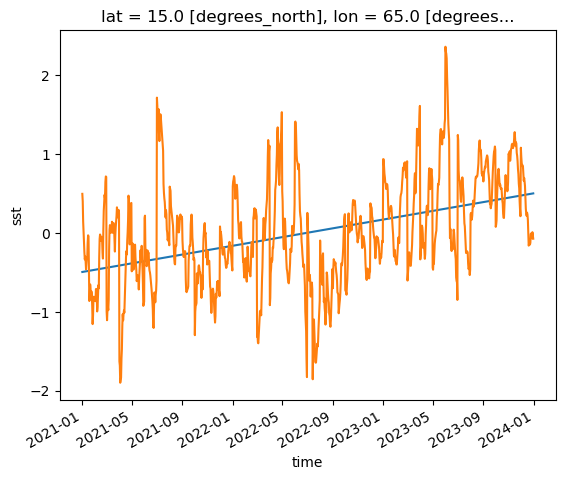

In [28]:
# Just to check, let's see how this linear trend actually fits our monthly anomaly data
fit.sel(lon=plon, lat=plat).plot()
monthly_anomaly.sel(lon=plon, lat=plat).plot()

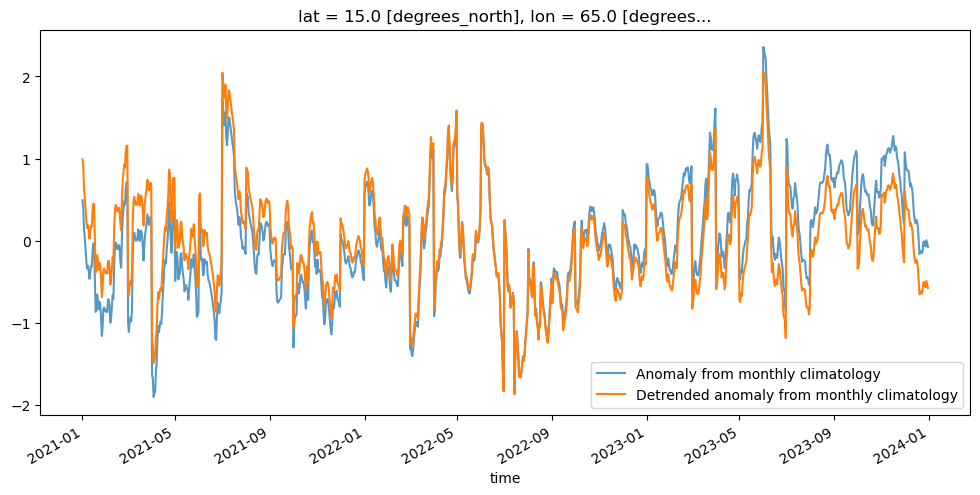

In [245]:
plt.figure(figsize=(12,5))
monthly_anomaly.sel(lon=plon, lat=plat).plot(alpha=0.75, label='Anomaly from monthly climatology')
(monthly_anomaly - fit).sel(lat=plat, lon=plon).plot( label='Detrended anomaly from monthly climatology')
plt.legend()